In [1]:
import numpy as np
import spateo as spt
import torch
import scanpy as sc
import scvelo as scv
import anndata as ad
import pandas as pd
import gseapy as gp
import seaborn as sns
import networkx as nx

2024-08-17 00:59:19.727143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 00:59:22.571282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/gpfs/share/home/2101110046/software/anaconda3/envs/spatial/lib/python3.8/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/gpfs/share/home/2101110046/software/anaconda3/envs/spatial/lib/python3.8/site-p

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.pyplot import rc_context
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker

In [3]:
from data import load_data, data_pre_processing_ARTISTA_ae
from utils import seed_all
seed_all(123456789)

## load data

In [4]:
adata = spt.read_h5ad('./data/ARTISTA_after_pp.h5ad')

## load model

In [5]:
model_path = './model_result/model_ARTISTA_2.pth'
rigid_transformation_path = './model_result/rigid_ARTISTA_2.pth'

model = torch.load(model_path, map_location=torch.device('cpu'))
rigid_transformation = torch.load(rigid_transformation_path, map_location=torch.device('cpu'))

In [6]:
ae_model_path = './model_result/ARTISTA_ae_10.pth'
ae_model = torch.load(ae_model_path, map_location=torch.device('cpu'))

In [7]:
model_anno_path = './model_result/model_anno_ARTISTA_2.pth'
model_anno = torch.load(model_anno_path, map_location=torch.device('cpu'))

## load relevant function

In [8]:
# The function v_x, v_z and g of switching to gene expression
def raw_gene_space_velocity(ot_model_path, ae_model_path, device=torch.device('cpu')):
    ot_model = torch.load(ot_model_path, map_location=device)
    ae_model =  torch.load(ae_model_path, map_location=device)
    def velocity(cur_cell_gene, cur_cell_spatial, t):
        latent_embed = ae_model.encode_mlp1(cur_cell_gene)
        velocity_latent = ot_model.hyper_net1(torch.tensor(t, dtype=torch.float32), torch.cat((latent_embed, cur_cell_spatial), axis=1))
        velocity_raw = (ae_model.decode_mlp1(latent_embed + 0.1*velocity_latent) - ae_model.decode_mlp1(latent_embed - 0.1*velocity_latent))/0.2
        return velocity_raw, velocity_latent
    return velocity

def raw_spatital_velocity(ot_model_path, ae_model_path, device=torch.device('cpu')):
    ot_model = torch.load(ot_model_path, map_location=device)
    ae_model =  torch.load(ae_model_path, map_location=device)
    def velocity(cur_cell_gene, cur_cell_spatial, t):
        latent_embed = ae_model.encode_mlp1(cur_cell_gene)
        spatial_velocity = ot_model.hyper_net2(torch.tensor(t, dtype=torch.float32), torch.cat((latent_embed, cur_cell_spatial), axis=1))
        return spatial_velocity
    return velocity

def raw_gene_space_growth(ot_model_path, ae_model_path, device=torch.device('cpu')):
    ot_model = torch.load(ot_model_path, map_location=device)
    ae_model =  torch.load(ae_model_path, map_location=device)
    def growth(cur_cell_gene, cur_cell_spatial, t):
        latent_embed = ae_model.encode_mlp1(cur_cell_gene)
        cell_growth = ot_model.hyper_net3(torch.tensor(t, dtype=torch.float32), torch.cat((latent_embed, cur_cell_spatial), axis=1))
        return cell_growth
    return growth

In [9]:
velocity = raw_gene_space_velocity(model_path, ae_model_path, device=torch.device('cpu'))
spatial_velocity = raw_spatital_velocity(model_path, ae_model_path, device=torch.device('cpu'))
growth_gene = raw_gene_space_growth(model_path, ae_model_path, device=torch.device('cpu'))

## data processing

In [10]:
data_pre_processing_ARTISTA_ae(adata, ae_model=ae_model)

1.0000000000000002
0.9999999999999999
0.9999999999999996
1.0
[[ 0.99703968 -0.07688869]
 [ 0.07688869  0.99703968]]
0.9999999999999998
0.9999999999999999
1.0000000000000002
1.0
[[ 0.99627382  0.08624658]
 [-0.08624658  0.99627382]]
1.0000000000000002
0.9999999999999999
1.0000000000000004
0.9999999999999999
[[ 0.99934372 -0.03622337]
 [ 0.03622337  0.99934372]]
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000002
[[ 0.9734116  -0.22906299]
 [ 0.22906299  0.9734116 ]]
3420.923605242506


AnnData object with n_obs × n_vars = 46189 × 2000
    obs: 'CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'inj_uninj', 'D_V', 'Annotation', 'n_genes', 'time'
    var: 'Gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'Annotation_colors', 'Injury_10DPI_rep1_SS200000147BL_B5', 'Injury_15DPI_rep4_FP200000266TR_E4', 'Injury_20DPI_rep2_SS200000147BL_B4', 'Injury_2DPI_rep1_SS200000147BL_D5', 'Injury_30DPI_rep2_FP200000264BL_A6', 'Injury_5DPI_rep1_SS200000147BL_D2', 'Injury_60DPI_rep3_FP200000264BL_A6', 'Injury_control_FP200000239BL_E3', 'angle_dict', 'hvg'
    obsm: 'X_pca', 'X_spatial', 'spatial', 'X_ae', 'X_input', 'spatial_input'
    layers: 'counts'

In [11]:
# Align data using the learned rigid body transformations
spatial_key = 'spatial_input'
integral_time = list(np.unique(adata.obs['time']))
time_pts = range(len(integral_time))
for i in time_pts:
    if i > 0:
        spatial_i = torch.tensor(adata[adata.obs.time == integral_time[i], :].obsm[spatial_key].copy(), dtype=torch.float32)
        spatial_i = rigid_transformation(spatial_i, i)
        adata.obsm[spatial_key][adata.obs.time == integral_time[i], :] = spatial_i.detach().numpy()

In [12]:
adata.obsm['X_spatial'] = adata.obsm[spatial_key]
adata.obsm['X_spatial_before_stVCR'] = adata.obsm['spatial'].copy()
adata.obsm['X_spatial_after_stVCR'] = adata.obsm['spatial_input'].copy()

In [13]:
var_names = adata.var_names
var_names_new = [s.split("|")[0].strip() for s in list(var_names)]

In [14]:
adata.var['var_names_new'] = var_names_new
adata.var_names = var_names_new

In [15]:
# set cell type color map
cell_type_Annotation = adata.obs['Annotation'].cat.categories.values
cell_type_color_map = dict(zip(cell_type_Annotation, adata.uns['Annotation_colors']))
cell_type_unique = np.unique(adata.obs['Annotation'])

In [16]:
adata_2DPI = adata[adata.obs.time==integral_time[0], :]
adata_5DPI = adata[adata.obs.time==integral_time[1], :]
adata_10DPI = adata[adata.obs.time==integral_time[2], :]
adata_15DPI = adata[adata.obs.time==integral_time[3], :]
adata_20DPI = adata[adata.obs.time==integral_time[4], :]

In [17]:
# set save path
save_path = './ARTISTA_figure/'

## Analysis and enrichment of growth-related genes

In [18]:
def compute_partial_growth_partial_gene(adata):
    cur_cell_gene = torch.tensor(adata.X.A, requires_grad=True, dtype=torch.float32)
    cur_cell_spatial = torch.tensor(adata.obsm['X_spatial_after_stVCR'], requires_grad=True, dtype=torch.float32)
    cur_cell_growth = growth_gene(cur_cell_gene, cur_cell_spatial, np.unique(adata.obs.time))
    grad_output = torch.ones_like(cur_cell_growth)
    cur_cell_growth.backward(grad_output, retain_graph=True)
    adata.layers['partial_growth_partial_gene'] = cur_cell_gene.grad.numpy().copy()
    cur_cell_gene.grad = None
    return adata

In [19]:
# load the relevant plot function
def plot_partial_growth_partial_gene(adata, title, figsize, gene, spatial_key='X_spatial_after_stVCR', cmap='coolwarm', pointsize=0.2, save_path=None):

    # color_value = adata.obs[color_key]

    gene_id = list(adata.var_names).index(gene)
    color_value = adata.layers['partial_growth_partial_gene'][:, gene_id]
    cur_max = np.maximum(np.abs(color_value.max()), np.abs(color_value.min()))
    # cur_max = 0.03
    norm = TwoSlopeNorm(vcenter=0, vmin=-cur_max, vmax=cur_max)
    mapper = ScalarMappable(norm=norm, cmap='coolwarm')
    
    # rc_context is used for the figure size
    with rc_context({"figure.figsize": figsize}):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.clear()
        ax.set_xlim(-1.0, 1.0)
        ax.set_ylim(-1.0, 1.0)
        
        ax.scatter(adata.obsm[spatial_key][:, -2], adata.obsm[spatial_key][:, -1],
                    c=color_value, cmap=cmap, alpha=1, norm=norm, s=pointsize, marker='o',edgecolors='none')
        ax.axis('off')
        
        plt.xticks([])
        plt.yticks([])
        
        # plt.xlabel('X')
        # plt.ylabel('Y')
        
        cbar = plt.colorbar(mapper)
        cbar.formatter = ticker.ScalarFormatter()
        cbar.formatter.set_scientific(True)
        cbar.formatter.set_powerlimits((0, 0))
        cbar.update_ticks()
        
        if title is not None:
            # plt.title(rf'$\frac{{\partial g}}{{\partial \mathit{{{gene}}}}}$')
            plt.title(rf'$\partial g / \partial \mathit{{{gene}}}$')
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()

In [20]:
cur_adata = adata_2DPI.copy()
compute_partial_growth_partial_gene(cur_adata)

AnnData object with n_obs × n_vars = 7668 × 2000
    obs: 'CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'inj_uninj', 'D_V', 'Annotation', 'n_genes', 'time'
    var: 'Gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'var_names_new'
    uns: 'Annotation_colors', 'Injury_10DPI_rep1_SS200000147BL_B5', 'Injury_15DPI_rep4_FP200000266TR_E4', 'Injury_20DPI_rep2_SS200000147BL_B4', 'Injury_2DPI_rep1_SS200000147BL_D5', 'Injury_30DPI_rep2_FP200000264BL_A6', 'Injury_5DPI_rep1_SS200000147BL_D2', 'Injury_60DPI_rep3_FP200000264BL_A6', 'Injury_control_FP200000239BL_E3', 'angle_dict', 'hvg'
    obsm: 'X_pca', 'X_spatial', 'spatial', 'X_ae', 'X_input', 'spatial_input', 'X_spatial_before_stVCR', 'X_spatial_after_stVCR'
    layers: 'counts', 'partial_growth_partial_gene'

In [21]:
growth_gene_reaEGC_list_top100 = list(cur_adata.var_names[np.argsort(np.mean(
    cur_adata.layers['partial_growth_partial_gene'][cur_adata.obs.Annotation == 'reaEGC', :], axis=0))[-100:][::-1]])
growth_gene_reaEGC_list_top100

['FABP7[nr]',
 'AMEX60DD021526',
 'AMEX60DD017847',
 'AMEX60DD054004',
 'AMEX60DD017849',
 'ARPP21',
 'RPS18',
 'SFRP1',
 'CALB2',
 'RPL7',
 'NPTXR',
 'RPL13',
 'RPS3[hs]',
 'RPL30',
 'RGR',
 'NTS',
 'RPL26',
 'PENK',
 'RPS4X',
 'SLC26A5',
 'RPL34',
 'LOC100555387[nr]',
 'NELL2',
 'NPTX1',
 'AMEX60DD035705',
 'TRH',
 'AMEX60DD009514',
 'FGFBP3',
 'LMO3',
 'RASL11B',
 'SRSF7',
 'GPX3',
 'ZGC:77650[nr]',
 'NMB',
 'SNCA',
 'CRABP2',
 'LOC115460661[nr]',
 'HS3ST1',
 'SLC6A11',
 'NEGR1',
 'SCG3',
 'AMEX60DD010632',
 'PAX6',
 'DBI',
 'CPLX3',
 'RALYL',
 'ZIC1',
 'TSHZ1',
 'GPR158',
 'ANGPTL7',
 'PCP4L1[nr]',
 'ZNF432[nr]',
 'TRMT9B',
 'DRD2',
 'MAB21L1',
 'PLPPR3',
 'NME3',
 'AMEX60DD004787',
 'GRM2',
 'LYPLA2',
 'GAA',
 'NDUFB2',
 'CCND1',
 'MUL1',
 'LOC105357518[nr]',
 'FOXP2',
 'AMEX60DD039037',
 'AMEX60DD049884',
 'LOC115556299[nr]',
 'DKK3',
 'UNC5D',
 'ADAMTS7',
 'LOC110481950[nr]',
 'AMEX60DD043203',
 'BRINP2',
 'SNX7',
 'LRRC10B',
 'AMEX60DD034111',
 'ARL4D',
 'LOC115480479[nr]',
 'A

In [22]:
# growth_top_100_enrichr = gp.enrichr(growth_gene_reaEGC_list_top100,
#                     gene_sets=['GO_Biological_Process_2018'],
#                     outdir=None)
# # trim (go:...)
# growth_top_100_enrichr.res2d.Term = growth_top_100_enrichr.res2d.Term.str.split(" \(GO").str[0]
# # dotplot
# gp.dotplot(growth_top_100_enrichr.res2d, figsize=(3,5), title="growth gene top 100", 
#            cmap = plt.cm.autumn_r)
# plt.show()

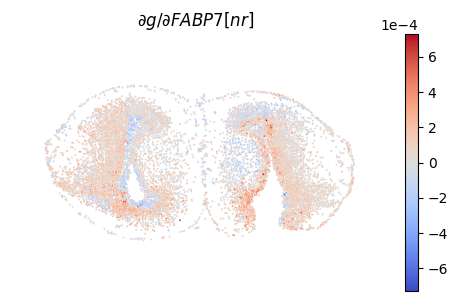

In [23]:
plot_partial_growth_partial_gene(cur_adata, title=True, figsize=(6, (5*2/3)), gene='FABP7[nr]', spatial_key='X_spatial_after_stVCR', cmap='coolwarm', 
                                 pointsize=2, save_path=None)

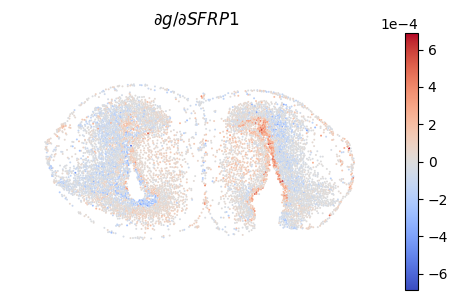

In [24]:
# gene SFRP1
plot_partial_growth_partial_gene(cur_adata, title=False, figsize=(6, (5*2/3)), gene='SFRP1', spatial_key='X_spatial_after_stVCR', cmap='coolwarm', 
                                 pointsize=2, save_path=None)

In [25]:
def plot_violinplot(adata, cell_type, gene, title=None, color_map=None, figsize=(6,4), save_path=None):
    adata_cur_gene = adata[:, gene].copy()
    data = []
    labels = []
    colors = []
    for i in range(len(cell_type)):
        data.append(adata_cur_gene[adata_cur_gene.obs.Annotation==cell_type[i]].X.A.squeeze())
        labels.append(cell_type[i])
        if color_map:
            colors.append(color_map[cell_type[i]])
        
    plt.figure(figsize=figsize)
    sns.violinplot(data=data, palette=colors)
    
    # 添加x轴标签
    plt.xticks(ticks=list(range(len(labels))), labels=labels)

    if title:
        plt.title('Gene Expression of '+gene+' across Cell Types')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    
    # 显示图形
    plt.show()

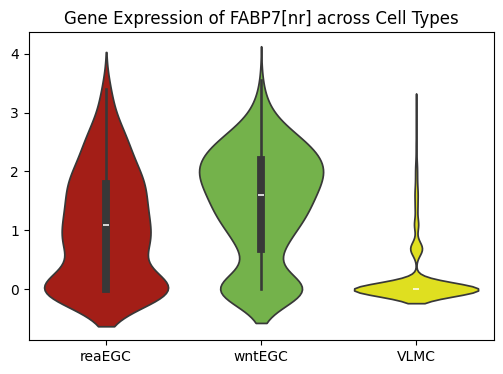

In [26]:
plot_violinplot(cur_adata, cell_type=['reaEGC', 'wntEGC', 'VLMC'], title = True, gene='FABP7[nr]', color_map=cell_type_color_map, figsize=(6,4), save_path=None)

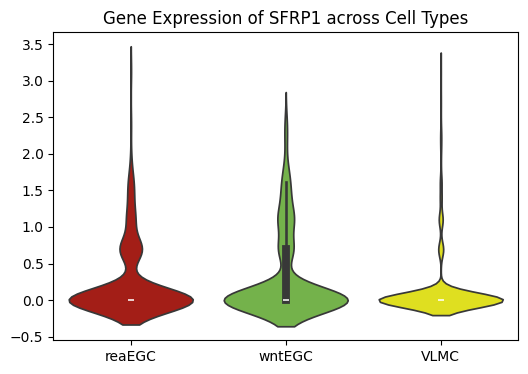

In [27]:
plot_violinplot(cur_adata, cell_type=['reaEGC', 'wntEGC', 'VLMC'], title = True, gene='SFRP1', color_map=cell_type_color_map, figsize=(6,4), save_path=None)

## Analysis and enrichment of migration-related genes

In [28]:
def compute_partial_norm_vz_partial_gene(adata):
    cur_cell_gene = torch.tensor(adata.X.A, requires_grad=True, dtype=torch.float32)
    cur_cell_spatial = torch.tensor(adata.obsm['X_spatial_after_stVCR'], requires_grad=True, dtype=torch.float32)
    
    cur_cell_spatial_velocity_norm = torch.norm(spatial_velocity(cur_cell_gene, cur_cell_spatial, np.unique(cur_adata.obs.time)), p=2, dim=1)
    grad_output = torch.ones_like(cur_cell_spatial_velocity_norm)
    cur_cell_spatial_velocity_norm.backward(grad_output, retain_graph=True)
    
    adata.layers['partial_norm_vz_partial_gene'] = cur_cell_gene.grad.numpy().copy()
    cur_cell_gene.grad = None
    return adata

In [29]:
# load the relevant plot function
def plot_partial_norm_vz_partial_gene(adata, title, figsize, gene, spatial_key='X_spatial_after_stVCR', cmap='coolwarm', pointsize=0.2, save_path=None):

    gene_id = list(adata.var_names).index(gene)
    color_value = adata.layers['partial_norm_vz_partial_gene'][:, gene_id]
    cur_max = np.maximum(np.abs(color_value.max()), np.abs(color_value.min()))
    norm = TwoSlopeNorm(vcenter=0, vmin=-cur_max, vmax=cur_max)
    mapper = ScalarMappable(norm=norm, cmap='coolwarm')
    
    # rc_context is used for the figure size
    with rc_context({"figure.figsize": figsize}):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.clear()
        ax.set_xlim(-1.0, 1.0)
        ax.set_ylim(-1.0, 1.0)
        
        ax.scatter(adata.obsm[spatial_key][:, -2], adata.obsm[spatial_key][:, -1],
                    c=color_value, cmap=cmap, alpha=1, norm=norm, s=pointsize, marker='o',edgecolors='none')
        ax.axis('off')
        
        plt.xticks([])
        plt.yticks([])
        
        # plt.xlabel('X')
        # plt.ylabel('Y')
        
        cbar = plt.colorbar(mapper)
        cbar.formatter = ticker.ScalarFormatter()
        cbar.formatter.set_scientific(True)
        cbar.formatter.set_powerlimits((0, 0))
        cbar.update_ticks()
        
        if title is not None:
            plt.title(rf'$\frac{{\partial \|v_z\|}}{{\partial \mathit{{{gene}}}}}$')
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()

In [30]:
cur_adata = adata_2DPI.copy()
compute_partial_norm_vz_partial_gene(cur_adata)

AnnData object with n_obs × n_vars = 7668 × 2000
    obs: 'CellID', 'spatial_leiden_e30_s8', 'Batch', 'cell_id', 'seurat_clusters', 'inj_uninj', 'D_V', 'Annotation', 'n_genes', 'time'
    var: 'Gene', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'var_names_new'
    uns: 'Annotation_colors', 'Injury_10DPI_rep1_SS200000147BL_B5', 'Injury_15DPI_rep4_FP200000266TR_E4', 'Injury_20DPI_rep2_SS200000147BL_B4', 'Injury_2DPI_rep1_SS200000147BL_D5', 'Injury_30DPI_rep2_FP200000264BL_A6', 'Injury_5DPI_rep1_SS200000147BL_D2', 'Injury_60DPI_rep3_FP200000264BL_A6', 'Injury_control_FP200000239BL_E3', 'angle_dict', 'hvg'
    obsm: 'X_pca', 'X_spatial', 'spatial', 'X_ae', 'X_input', 'spatial_input', 'X_spatial_before_stVCR', 'X_spatial_after_stVCR'
    layers: 'counts', 'partial_norm_vz_partial_gene'

In [31]:
migration_gene_list_top100 = list(cur_adata.var_names[np.argsort(np.mean(
    cur_adata.layers['partial_norm_vz_partial_gene'], axis=0))[-100:][::-1]])
migration_gene_list_top100

['SCGN',
 'TRH',
 'H355_001130[nr]',
 'AMEX60DD029717',
 'SLC1A3',
 'PENK',
 'PCP4L1[nr]',
 'AMEX60DD017849',
 'LAMP5',
 'SLC6A11',
 'DR999_PMT12449[nr]',
 'PTN[nr]',
 'ZIC1',
 'AMEX60DD017847',
 'LMO3',
 'LOC115460661[nr]',
 'SFRP1',
 'NECAB1[nr]',
 'LOC115079518[nr]',
 'RGR',
 'RASL11B',
 'ERBB4',
 'GLUD1',
 'EDNRB',
 'WIPF3[nr]',
 'AMEX60DD054004',
 'MLC1',
 'CHRM4',
 'SHISA6',
 'ECM1',
 'NPPC4[nr]',
 'UNC5D',
 'ZIC2',
 'GJA1',
 'TMBIM6',
 'LOC113406115[nr]',
 'CYP7B1',
 'SLC4A4',
 'RGS5',
 'CHRDL1',
 'GRM2',
 'NTS',
 'LRATD1',
 'SULF2',
 'KCNG1',
 'KCNJ10',
 'SNCA',
 'CD9',
 'PHACTR2',
 'CDKN2D',
 'DOCK4',
 'ANO5',
 'TNC',
 'FXYD1',
 'GPR78[nr]',
 'GFAP',
 'PAX6',
 'AMEX60DDU001001926',
 'SEMA3A',
 'PLP1',
 'CNTNAP5',
 'CNR1',
 'ZGC:77650[nr]',
 'QKI[nr]',
 'LOC115478996[nr]',
 'DLX6',
 'NDUFB2',
 'NDNF',
 'AMEX60DD054908',
 'SQSTM1[nr]',
 'SPARC',
 'GLUL.L[nr]',
 'POMGNT1',
 'HIF3A',
 'FZD7',
 'AMEX60DD022128',
 'BOX5[nr]',
 'BTBD17',
 'HBZ[hs]',
 'BAIAP3',
 'SWAP70',
 'LOC1087066

In [32]:
# migration_top_100_enrichr = gp.enrichr(migration_gene_list_top100,
#                     gene_sets=['GO_Biological_Process_2018'],
#                     outdir=None)
# # trim (go:...)
# migration_top_100_enrichr.res2d.Term = migration_top_100_enrichr.res2d.Term.str.split(" \(GO").str[0]
# # dotplot
# gp.dotplot(migration_top_100_enrichr.res2d, figsize=(3,5), title="migration gene top 100", 
#            cmap = plt.cm.autumn_r)
# plt.show()

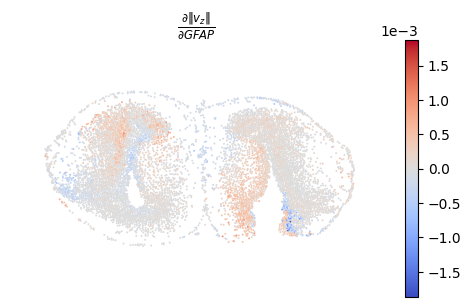

In [33]:
plot_partial_norm_vz_partial_gene(cur_adata, title=True, figsize=(6, (5*2/3)), gene='GFAP', spatial_key='X_spatial_after_stVCR', cmap='coolwarm', 
                                 pointsize=2, save_path=None)

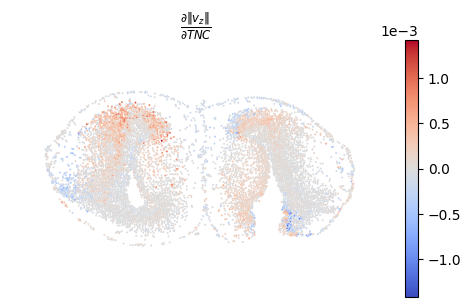

In [34]:
plot_partial_norm_vz_partial_gene(cur_adata, title=True, figsize=(6, (5*2/3)), gene='TNC', spatial_key='X_spatial_after_stVCR', cmap='coolwarm', 
                                 pointsize=2, save_path=None)

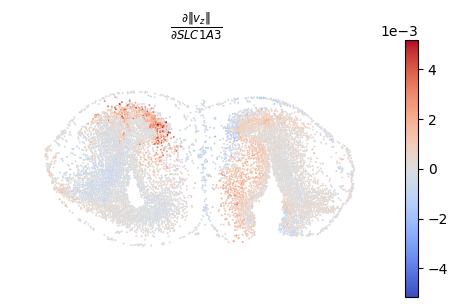

In [35]:
plot_partial_norm_vz_partial_gene(cur_adata, title=True, figsize=(6, (5*2/3)), gene='SLC1A3', spatial_key='X_spatial_after_stVCR', cmap='coolwarm', 
                                 pointsize=2, save_path=None)

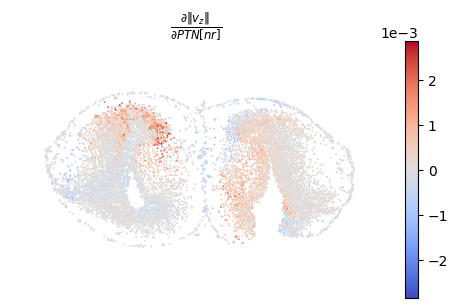

In [36]:
plot_partial_norm_vz_partial_gene(cur_adata, title=True, figsize=(6, (5*2/3)), gene='PTN[nr]', spatial_key='X_spatial_after_stVCR', cmap='coolwarm', 
                                 pointsize=2, save_path=None)

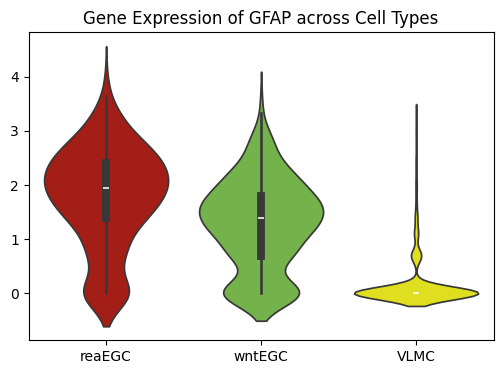

In [37]:
plot_violinplot(cur_adata, cell_type=['reaEGC', 'wntEGC', 'VLMC'], title = True, gene='GFAP', color_map=cell_type_color_map, figsize=(6,4), save_path=None)

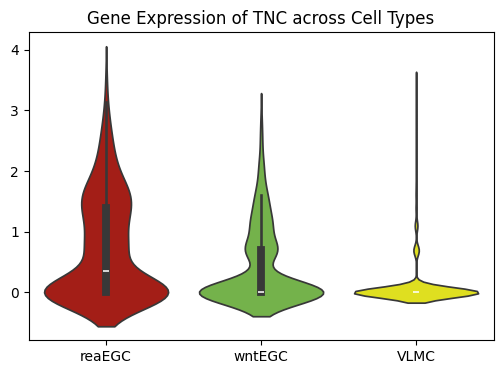

In [38]:
plot_violinplot(cur_adata, cell_type=['reaEGC', 'wntEGC', 'VLMC'], title = True, gene='TNC', color_map=cell_type_color_map, figsize=(6,4), save_path=None)

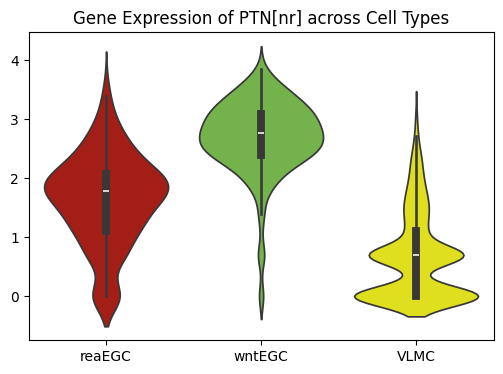

In [39]:
plot_violinplot(cur_adata, cell_type=['reaEGC', 'wntEGC', 'VLMC'], title = True, gene='PTN[nr]', color_map=cell_type_color_map, figsize=(6,4), save_path=None)

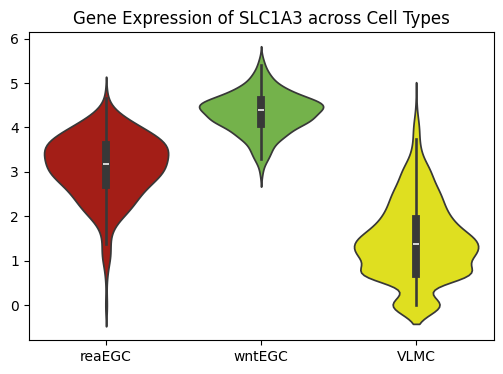

In [40]:
plot_violinplot(cur_adata, cell_type=['reaEGC', 'wntEGC', 'VLMC'], title = True, gene='SLC1A3', color_map=cell_type_color_map, figsize=(6,4), save_path=None)

## Construction and visualization of gene regulatory networks

In [41]:
def construct_cell_type_specific_gene_regulatory_network(adata, gene_list, cell_type=None):
    gene_number = len(gene_list)
    gene_names_list = list(adata.var_names)
    gene_id = [gene_names_list.index(cur_gene) for cur_gene in gene_list]
    cts_grn = np.zeros((gene_number, gene_number))


    if cell_type:
        adata = adata[adata.obs.Annotation == cell_type]
    
    cur_cell_gene = torch.tensor(adata.X.A, requires_grad=True, dtype=torch.float32)
    cur_cell_spatial = torch.tensor(adata.obsm['X_spatial_after_stVCR'], requires_grad=True, dtype=torch.float32)
    cur_velocity = velocity(cur_cell_gene, cur_cell_spatial, np.unique(adata.obs.time))[0]

    for i in range(gene_number):
        cur_cell_gene.grad = None
        cur_gene_velocity = cur_velocity[:, gene_id[i]]
        grad_output = torch.ones_like(cur_gene_velocity)
        cur_gene_velocity.backward(grad_output, retain_graph=True)
        cur_gene_grad = torch.mean(cur_cell_gene.grad, axis=0)
        cts_grn[i, :] = cur_gene_grad[gene_id]
    return cts_grn

In [42]:
def plot_grn_heatmap(regulation_matrix, gene_list, max_value=None, title=None, figsize=(8,6), save_path=None):
    if max_value:
        cur_max = max_value
    else:
        cur_max = np.abs(regulation_matrix).max()

    norm = TwoSlopeNorm(vcenter=0, vmin=-cur_max, vmax=cur_max)
    mapper = ScalarMappable(norm=norm, cmap='coolwarm')
    
    plt.figure(figsize=figsize)
    plt.imshow(regulation_matrix, cmap='coolwarm', norm=norm)
    plt.colorbar(mapper)
    
    plt.xticks(np.arange(len(gene_list)), gene_list)
    plt.yticks(np.arange(len(gene_list)), gene_list)
    plt.xticks(rotation=90)
    plt.xlabel('target gene')
    plt.ylabel('source gene')

    if title:
        plt.title(title)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [43]:
def plot_grn_graph(regulation_matrix, gene_list, threshold=0.01, node_colors='lightblue', title=None, figsize=(8,8.5), save_path=None):
    # 创建一个有向图
    G = nx.DiGraph()

    num_genes = len(gene_list)
    
    # 添加节点（基因）
    for i in range(num_genes):
        G.add_node(i, label=gene_list[i])
    
    # 添加边（调控关系），只添加调控强度大于某个阈值的边
    for i in range(num_genes):
        for j in range(num_genes):
            if i != j and abs(regulation_matrix[i, j]) > threshold:
                G.add_edge(i, j, weight=regulation_matrix[i, j])
            # G.add_edge(i, j, weight=regulation_matrix[i, j])
    
    # 绘制网络图
    pos = nx.circular_layout(G)  # 使用圆形布局
    # pos = nx.spring_layout(G)
    
    # 根据权重调整边的宽度和颜色
    # 设置边宽度的范围
    min_width = 1.0
    max_width = 6.0
    edge_weights_list = [np.abs(G[u][v]['weight']) for u, v in G.edges()]
    if edge_weights_list:
        normalized_widths = np.clip(edge_weights_list, 0, max(edge_weights_list))  # 归一化
        edge_widths = min_width + (max_width - min_width) * (normalized_widths - min(edge_weights_list)) / (max(edge_weights_list) - min(edge_weights_list))
    else:
        edge_widths = 0.0
    
    # 边的颜色设置：负值为蓝色，正值为红色
    # edge_colors = ['blue' if G[u][v]['weight'] < 0 else 'red' for u, v in G.edges()]
    # edge_colors = ['darkblue' if G[u][v]['weight'] < 0 else 'darkred' for u, v in G.edges()]
    edge_colors = ['#003366' if G[u][v]['weight'] < 0 else '#CC0000' for u, v in G.edges()]
    
    
    
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=edge_widths, edge_color=edge_colors, arrowstyle='-|>', arrowsize=50, style='solid')
    nx.draw_networkx_labels(G, pos, labels={i: gene_list[i] for i in G.nodes()})

    plt.axis('off')
    
    
    # 省略边标签的绘制
    if title:
        plt.title(title)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

In [44]:
rea_marker = ['KRT18', 'ECM1', 'GFAP', 'VIM', 'TNC', 'S100A10', 'HMOX1']
# EGC_marker = ['SLC1A3', 'EDNRB', 'GLUD1','CHRM4', 'WNT8B', 'SFRP1']
# gene_list = rea_marker + EGC_marker
gene_list = rea_marker

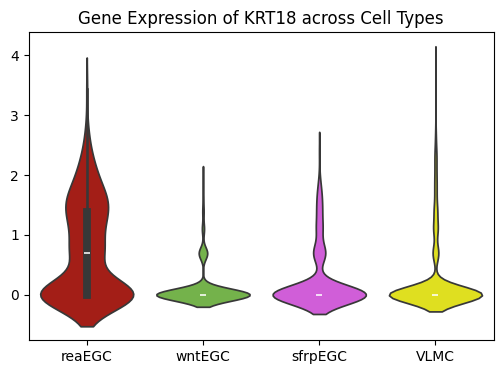

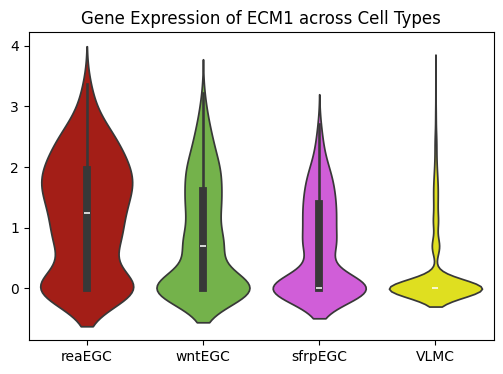

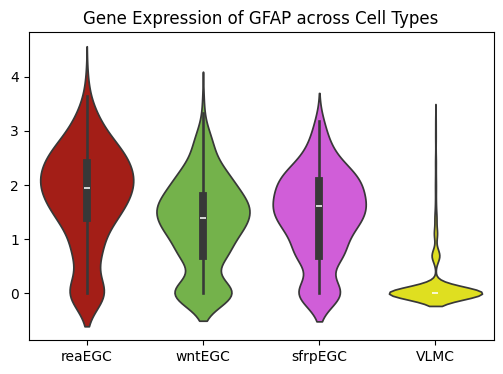

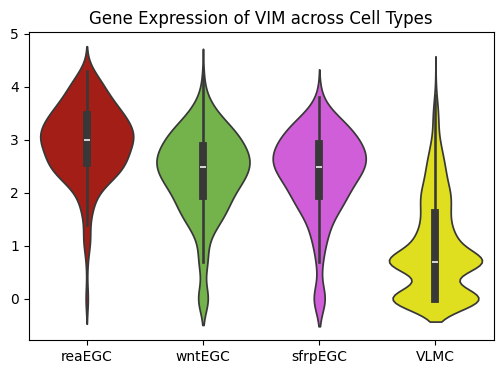

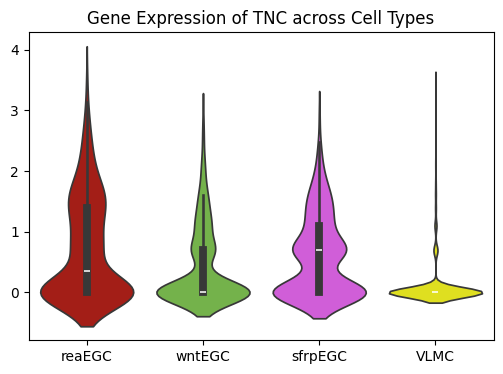

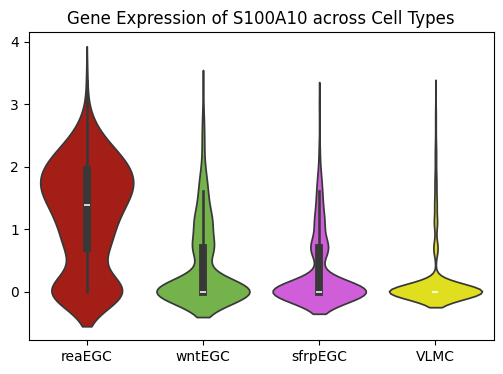

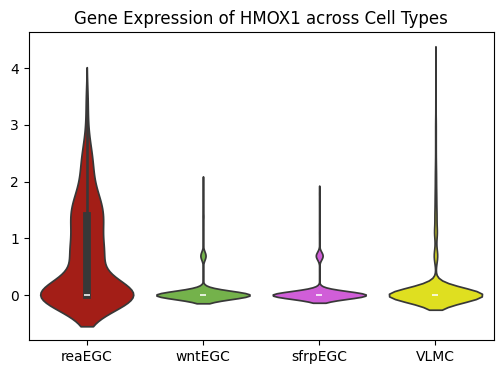

In [45]:
for i in range(len(gene_list)):
    plot_violinplot(cur_adata, cell_type=['reaEGC', 'wntEGC', 'sfrpEGC','VLMC'], title = True, gene=gene_list[i], color_map=cell_type_color_map, figsize=(6,4), save_path=None)

In [46]:
rea_EGC_grn = construct_cell_type_specific_gene_regulatory_network(adata_2DPI, gene_list=gene_list, cell_type='reaEGC')
sfrp_EGC_grn = construct_cell_type_specific_gene_regulatory_network(adata_2DPI, gene_list=gene_list, cell_type='sfrpEGC')
wnt_EGC_grn = construct_cell_type_specific_gene_regulatory_network(adata_2DPI, gene_list=gene_list, cell_type='wntEGC')
rib_EGC_grn = construct_cell_type_specific_gene_regulatory_network(adata_2DPI, gene_list=gene_list, cell_type='ribEGC')
VLMC_grn = construct_cell_type_specific_gene_regulatory_network(adata_2DPI, gene_list=gene_list, cell_type='VLMC')

rea_EGC_grn_5DPI = construct_cell_type_specific_gene_regulatory_network(adata_5DPI, gene_list=gene_list, cell_type='reaEGC')
rea_EGC_grn_10DPI = construct_cell_type_specific_gene_regulatory_network(adata_10DPI, gene_list=gene_list, cell_type='reaEGC')
rea_EGC_grn_15DPI = construct_cell_type_specific_gene_regulatory_network(adata_15DPI, gene_list=gene_list, cell_type='reaEGC')

In [47]:
node_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow', 'lightpink', 'lightgray', 'lightcyan']
max_value = 0.03
threshold=0.005

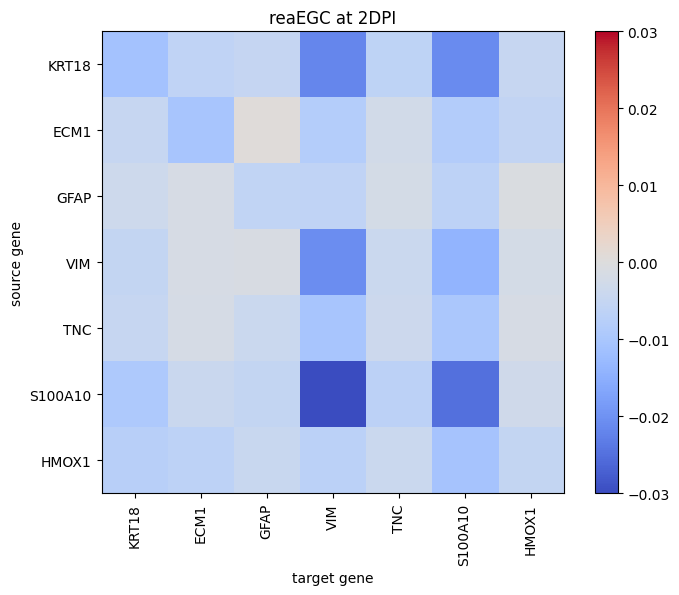

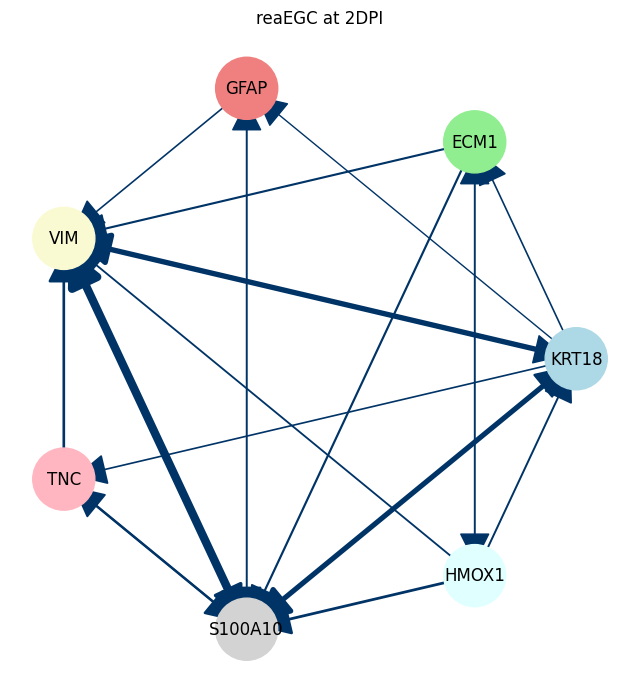

In [48]:
plot_grn_heatmap(rea_EGC_grn, title='reaEGC at 2DPI', gene_list=gene_list, max_value=max_value)
plot_grn_graph(rea_EGC_grn, title='reaEGC at 2DPI', gene_list=gene_list, node_colors=node_colors, threshold=threshold)

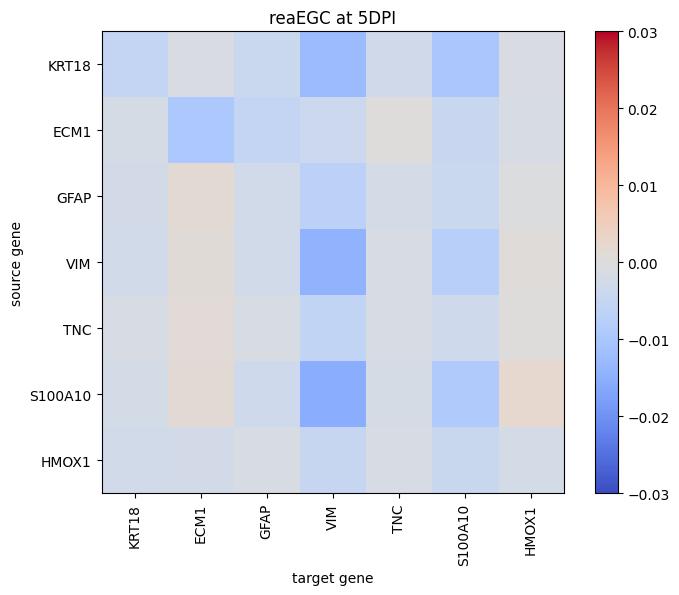

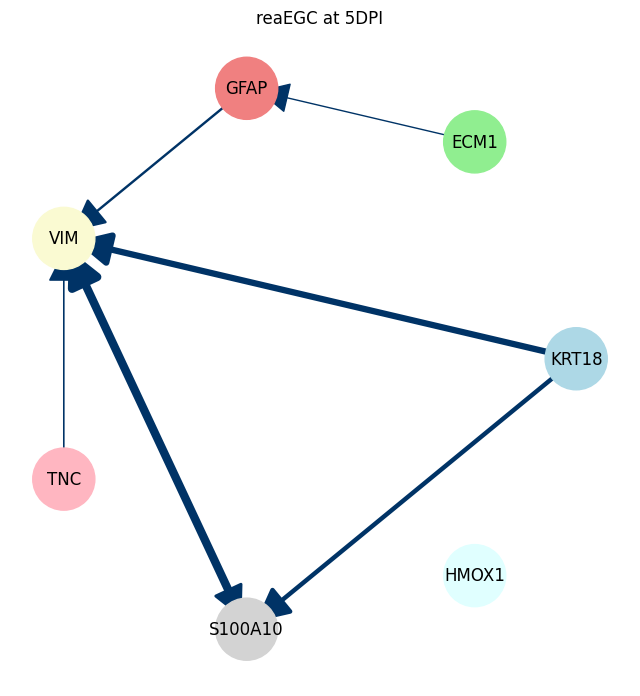

In [49]:
plot_grn_heatmap(rea_EGC_grn_5DPI, title='reaEGC at 5DPI', gene_list=gene_list, max_value=max_value)
plot_grn_graph(rea_EGC_grn_5DPI, title='reaEGC at 5DPI', gene_list=gene_list, node_colors=node_colors, threshold=threshold)

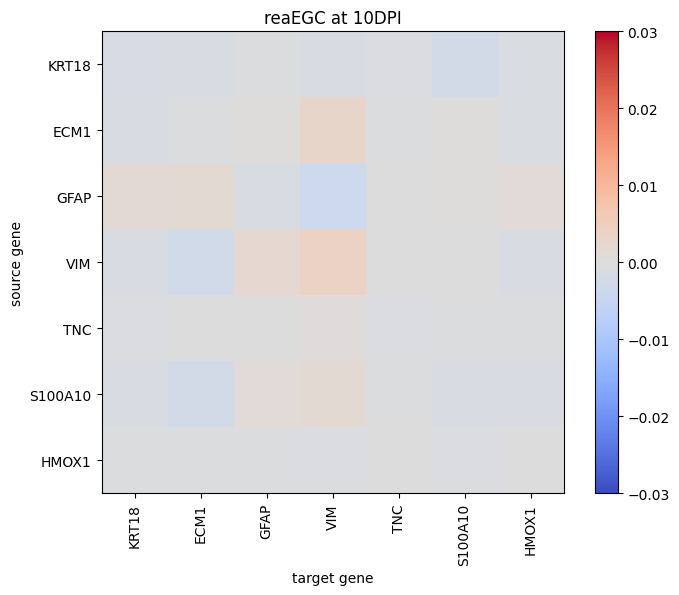

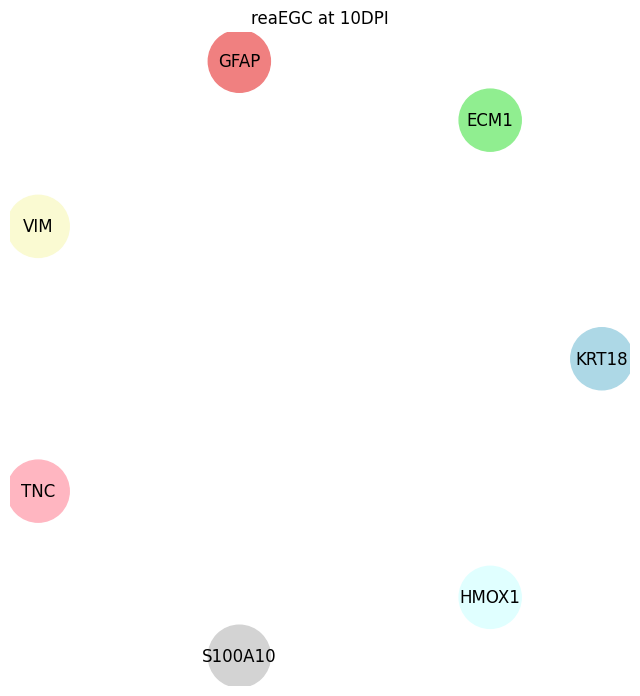

In [50]:
plot_grn_heatmap(rea_EGC_grn_10DPI, title='reaEGC at 10DPI', gene_list=gene_list, max_value=max_value)
plot_grn_graph(rea_EGC_grn_10DPI, title='reaEGC at 10DPI', gene_list=gene_list, node_colors=node_colors, threshold=threshold)

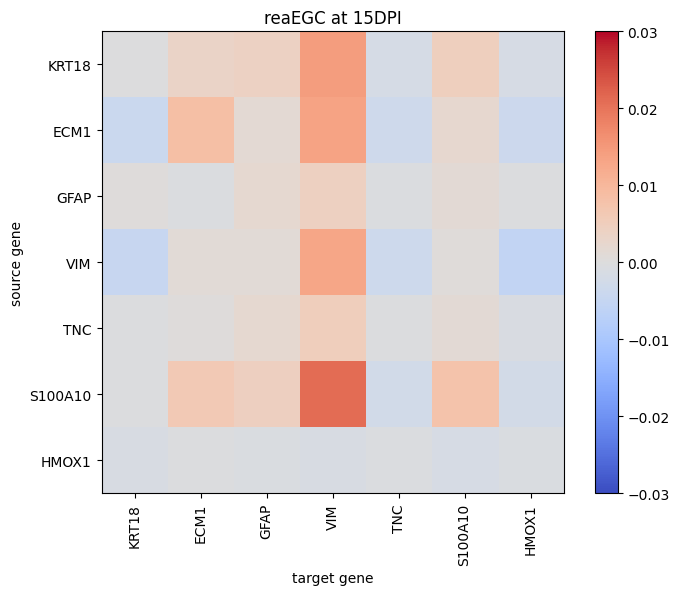

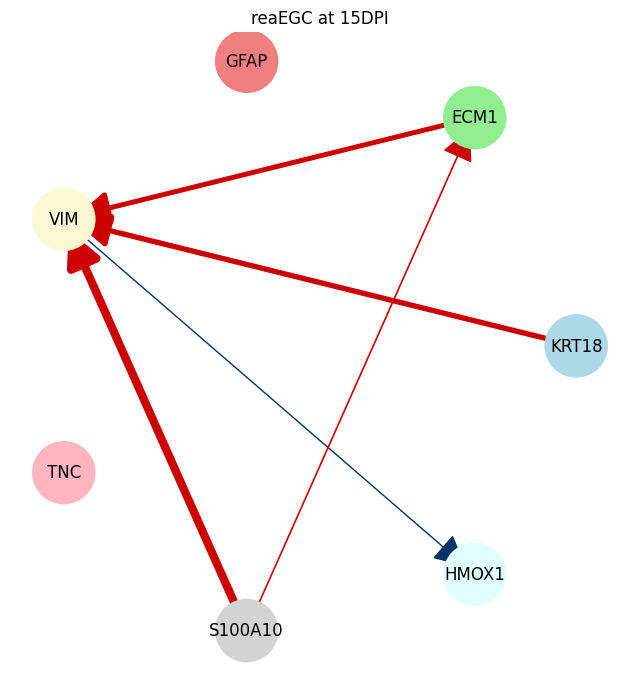

In [51]:
plot_grn_heatmap(rea_EGC_grn_15DPI, title='reaEGC at 15DPI', gene_list=gene_list, max_value=max_value)
plot_grn_graph(rea_EGC_grn_15DPI, title='reaEGC at 15DPI', gene_list=gene_list, node_colors=node_colors, threshold=threshold)

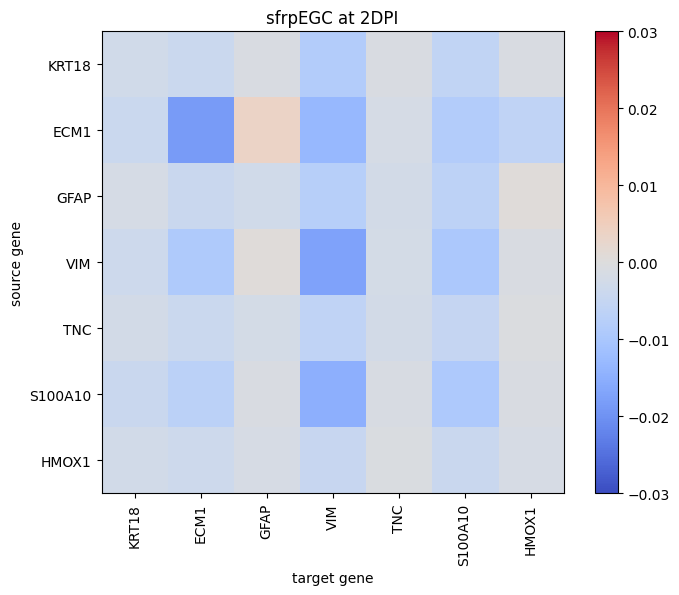

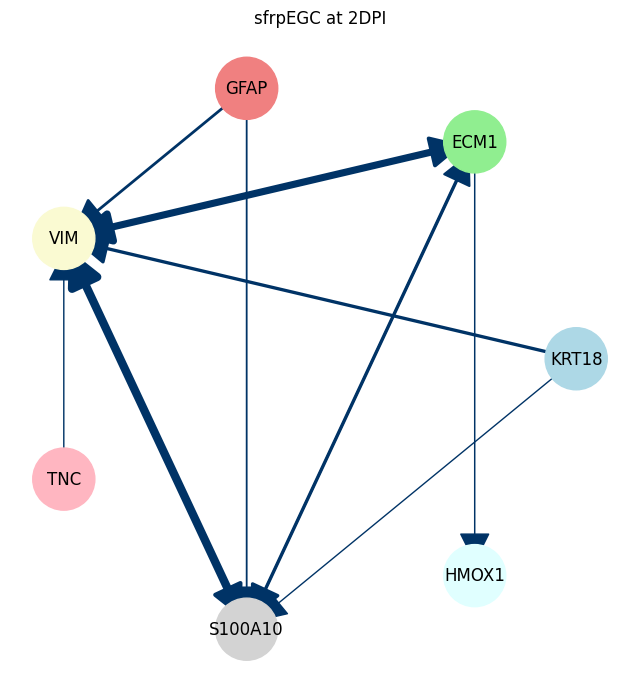

In [52]:
plot_grn_heatmap(sfrp_EGC_grn, title='sfrpEGC at 2DPI', gene_list=gene_list, max_value=max_value)
plot_grn_graph(sfrp_EGC_grn, title='sfrpEGC at 2DPI', gene_list=gene_list, node_colors=node_colors, threshold=threshold)

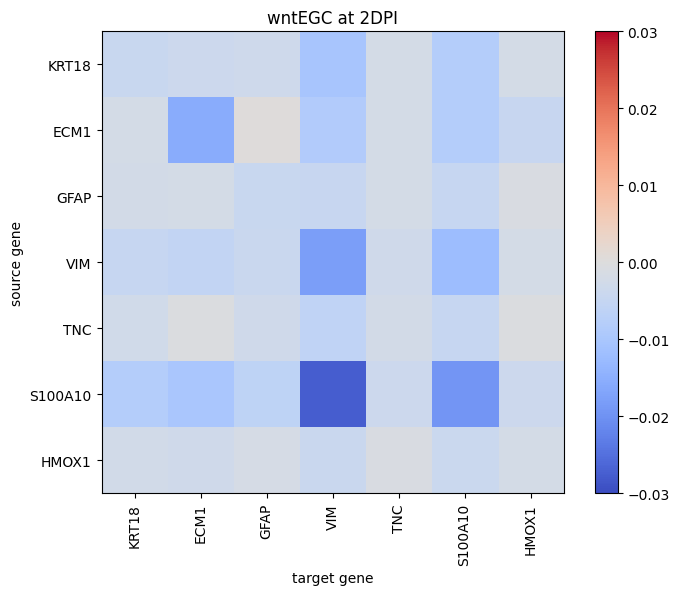

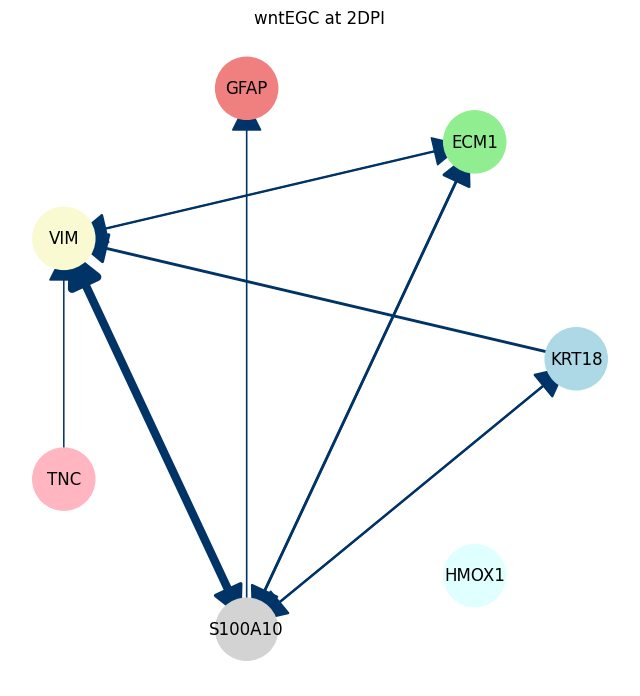

In [53]:
plot_grn_heatmap(wnt_EGC_grn, title='wntEGC at 2DPI', gene_list=gene_list, max_value=max_value)
plot_grn_graph(wnt_EGC_grn, title='wntEGC at 2DPI', gene_list=gene_list, node_colors=node_colors, threshold=threshold)

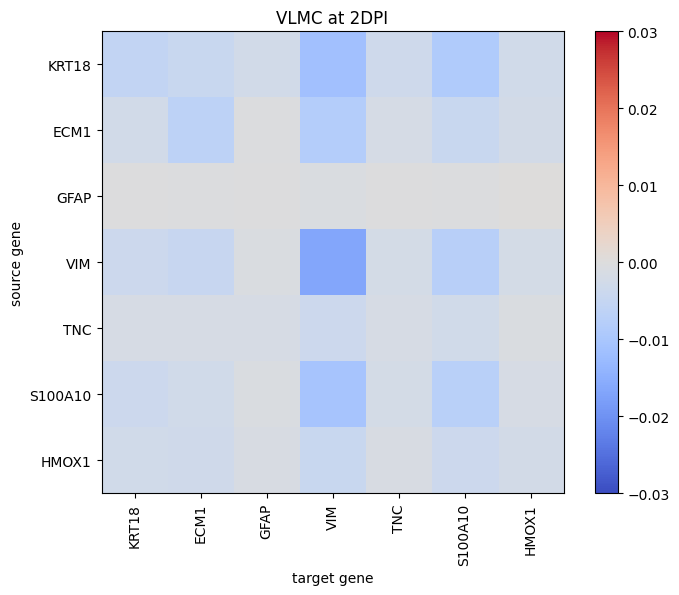

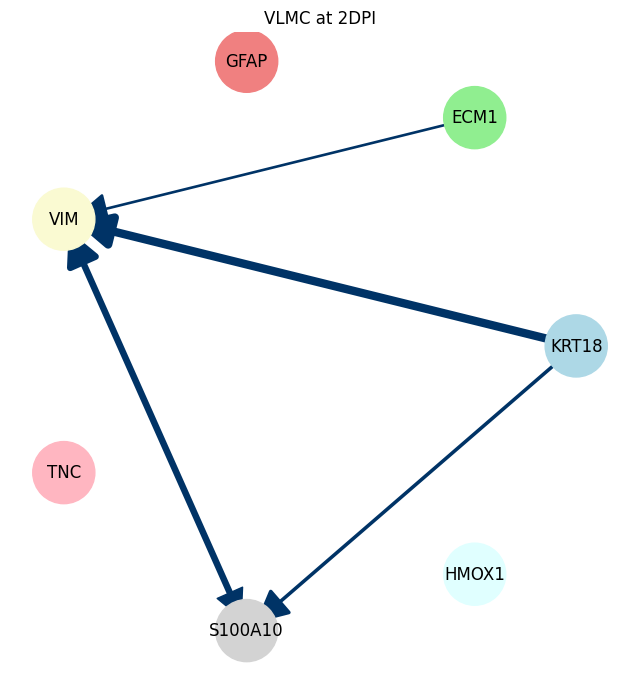

In [54]:
plot_grn_heatmap(VLMC_grn, title='VLMC at 2DPI', gene_list=gene_list, max_value=max_value)
plot_grn_graph(VLMC_grn, title='VLMC at 2DPI', gene_list=gene_list, node_colors=node_colors, threshold=threshold)

In [55]:
def plot_subtype(adata, types, color_map, title, figsize=(8,6), pointsize=1, save_path=None, show_legend=False):
    from pandas.api.types import CategoricalDtype
    if show_legend:
        legend_loc = 'right margin'
    else:
        legend_loc = 'none'
    
    adata = adata.copy()
    adata.obs['subtype'] = ['other'] * adata.n_obs
    subtype_colors = []
    for i in range(len(types)):
        adata.obs['subtype'][adata.obs.Annotation == types[i]] = types[i]
        subtype_colors.append(color_map[types[i]])
        
    grade_dtype = CategoricalDtype(categories=types+['other'], ordered=True)
    adata.obs['subtype'] = pd.Series(adata.obs.subtype).astype(grade_dtype)

    adata.uns['subtype_colors'] = subtype_colors + ['#D3D3D3']
    
    # rc_context is used for the figure size
    with rc_context({"figure.figsize": figsize}):
        fig, ax = plt.subplots()
        sc.pl.scatter(adata, basis='spatial_after_stVCR', color='subtype',
                      size = pointsize, legend_loc=legend_loc, show=False, ax=ax)
        if title:
            plt.title(title)
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()

In [56]:
# Set parameters
sc.set_figure_params(dpi=100, dpi_save=400, frameon=False, fontsize=8, transparent=True)
sc.settings.verbosity = 0
sc.logging.print_header()
plt.rcParams['axes.grid'] = False

scanpy==1.9.8 anndata==0.9.2 umap==0.5.5 numpy==1.24.3 scipy==1.10.1 pandas==1.3.5 scikit-learn==1.3.0 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.0 pynndescent==0.5.11


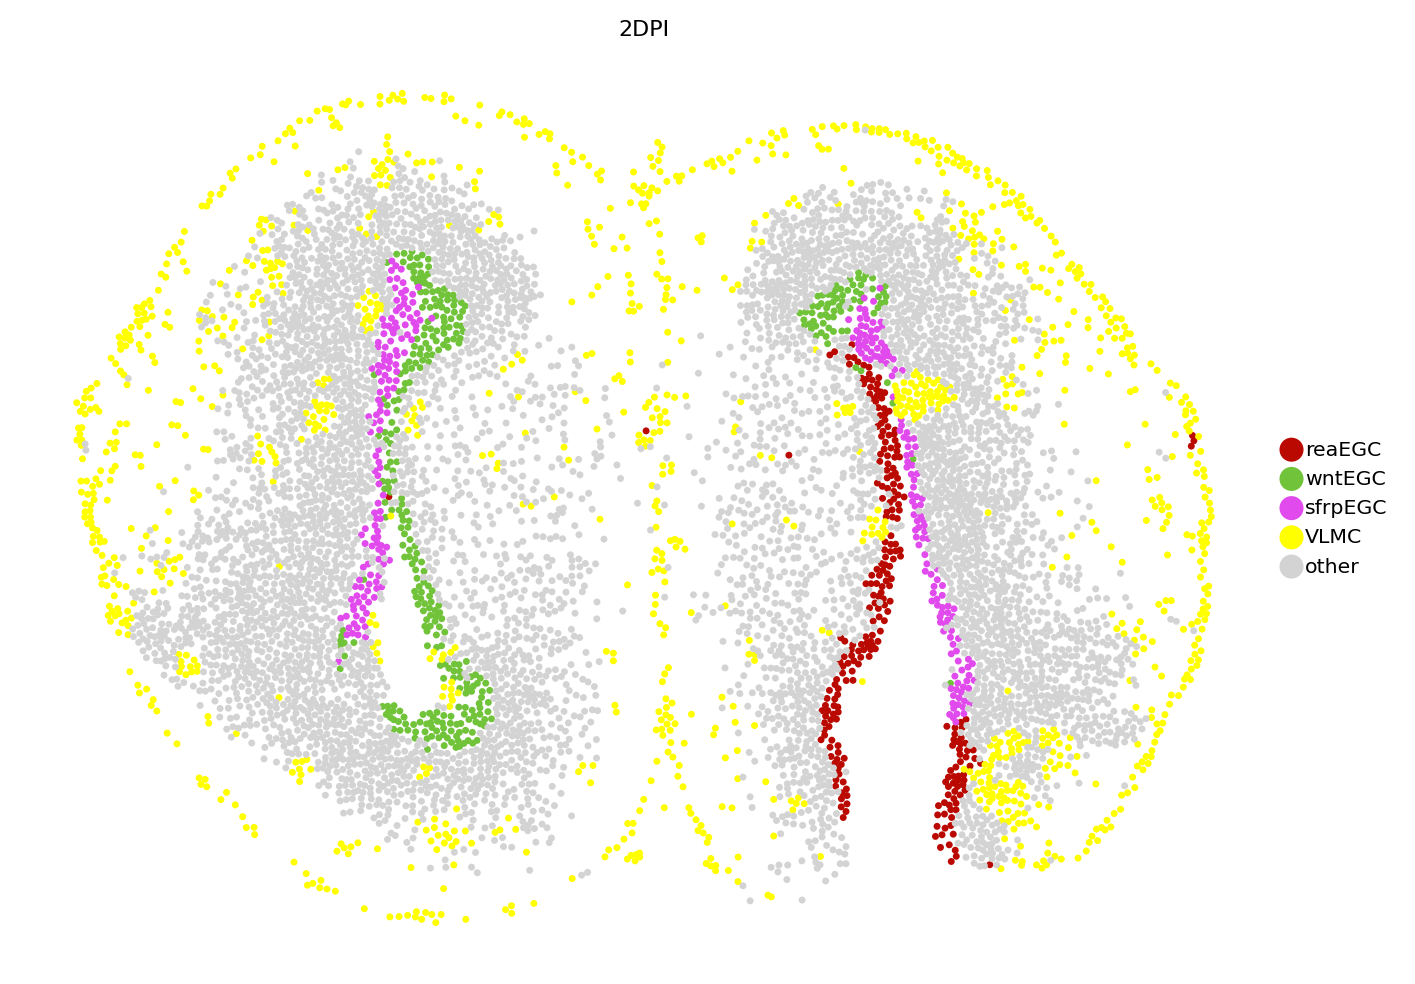

In [58]:
plot_subtype(cur_adata, types=['reaEGC', 'wntEGC', 'sfrpEGC', 'VLMC'], color_map=cell_type_color_map, title='2DPI', figsize=(8,6), 
             pointsize=25, show_legend=True)